In [1]:
import sympy
import sympy.physics.mechanics as mech
sympy.init_printing()

In [17]:
phi, theta, psi, rot_x, rot_y, rot_z, v_N, v_E, v_D, gyro_bias_N, gyro_bias_E, gyro_bias_D, \
pos_N, pos_E, asl, terrain_asl, baro_bias, w_N, w_E, w_D, d, agl= \
    sympy.symbols('phi, theta, psi, rot_x, rot_y, rot_z, v_N, v_E, v_D, gyro_bias_N, gyro_bias_E, gyro_bias_D,'
                   'pos_N, pos_E, asl, terrain_asl, baro_bias, w_N, w_E, w_D, d, agl')    

frame_n = mech.ReferenceFrame('n')
frame_r = frame_n.orientnew('r', 'Quaternion', (1, rot_x, rot_y, rot_z))
#frame_b = frame_r.orientnew('b', 'Quaternion', (q_0, q_1, q_2, q_3))
# easier to see where we get divide by zeros if we express dcm in euler angles
frame_b = frame_r.orientnew('b', 'Body', (psi, theta, phi), '321')
C_rb = frame_b.dcm(frame_r)
sub_C_rb = {}
for i in range(3):
    for j in range(3):
        sub_C_rb[C_rb[i, j]] = sympy.Symbol('C_rb({:d}, {:d})'.format(i, j))
        sub_C_rb[-C_rb[i, j]] = -sympy.Symbol('C_rb({:d}, {:d})'.format(i, j))
sub_C_rb
sub_lin = {
    rot_x: 0,
    rot_y: 0,
    rot_z: 0,
}
sub_agl = {
    asl - terrain_asl: agl
}

In [3]:
sub_C_rb

In [4]:
xe = sympy.Matrix([rot_x, rot_y, rot_z, v_N, v_E, v_D, gyro_bias_N, gyro_bias_E, gyro_bias_D,
                   pos_N, pos_E, asl, terrain_asl, baro_bias, w_N, w_E, w_D])
xe.T

[rotₓ  rot_y  rot_z  v_N  v_E  v_D  gyro_bias_N  gyro_bias_E  gyro_bias_D  pos
_N  pos_E  asl  terrainₐₛₗ  baro_bias  w_N  w_E  w_D]

## Airspeed

In [5]:
wind_n = w_N*frame_n.x + w_E*frame_n.y + w_D*frame_n.z
vel_n = v_N*frame_n.x + v_E*frame_n.y + v_D*frame_n.z

In [6]:
rel_wind = wind_n - vel_n
y_airspeed = sympy.Matrix([rel_wind.dot(-frame_b.x)]).subs(sub_C_rb)
y_airspeed

⎡             ⎛                                                               
⎣(-v_D + w_D)⋅⎝-C_rb(0, 0)⋅(2⋅rotₓ⋅rot_z - 2⋅rot_y) - C_rb(0, 1)⋅(2⋅rotₓ + 2⋅r

                         ⎛      2        2        2    ⎞⎞                ⎛    
ot_y⋅rot_z) - C_rb(0, 2)⋅⎝- rotₓ  - rot_y  + rot_z  + 1⎠⎠ + (-v_E + w_E)⋅⎝-C_r

                                              ⎛      2        2        2    ⎞ 
b(0, 0)⋅(2⋅rotₓ⋅rot_y + 2⋅rot_z) - C_rb(0, 1)⋅⎝- rotₓ  + rot_y  - rot_z  + 1⎠ 

                                      ⎞                ⎛             ⎛    2   
- C_rb(0, 2)⋅(-2⋅rotₓ + 2⋅rot_y⋅rot_z)⎠ + (-v_N + w_N)⋅⎝- C_rb(0, 0)⋅⎝rotₓ  - 

     2        2    ⎞                                                          
rot_y  - rot_z  + 1⎠ - C_rb(0, 1)⋅(2⋅rotₓ⋅rot_y - 2⋅rot_z) - C_rb(0, 2)⋅(2⋅rot

                  ⎞⎤
ₓ⋅rot_z + 2⋅rot_y)⎠⎦

In [13]:
H_airspeed = y_airspeed.jacobian(xe).subs(sub_lin)
H_airspeed.T

⎡-2⋅C_rb(0, 1)⋅(-v_D + w_D) + 2⋅C_rb(0, 2)⋅(-v_E + w_E)⎤
⎢                                                      ⎥
⎢2⋅C_rb(0, 0)⋅(-v_D + w_D) - 2⋅C_rb(0, 2)⋅(-v_N + w_N) ⎥
⎢                                                      ⎥
⎢-2⋅C_rb(0, 0)⋅(-v_E + w_E) + 2⋅C_rb(0, 1)⋅(-v_N + w_N)⎥
⎢                                                      ⎥
⎢                      C_rb(0, 0)                      ⎥
⎢                                                      ⎥
⎢                      C_rb(0, 1)                      ⎥
⎢                                                      ⎥
⎢                      C_rb(0, 2)                      ⎥
⎢                                                      ⎥
⎢                          0                           ⎥
⎢                                                      ⎥
⎢                          0                           ⎥
⎢                                                      ⎥
⎢                          0                           ⎥
⎢                              

## Distance

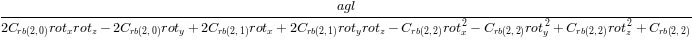

In [8]:
d_eq = sympy.solve((d*frame_b.z).dot(frame_n.z).subs(sub_C_rb) - (asl - terrain_asl), d)[0]
d_eq.subs(sub_agl)

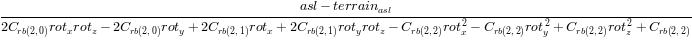

In [9]:
y_dist = sympy.Matrix([d_eq])
y_dist[0]

In [14]:
H_distance = y_dist.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_distance.T

⎡-2⋅C_rb(2, 1)⋅agl ⎤
⎢──────────────────⎥
⎢             2    ⎥
⎢   C_rb(2, 2)     ⎥
⎢                  ⎥
⎢ 2⋅C_rb(2, 0)⋅agl ⎥
⎢ ──────────────── ⎥
⎢             2    ⎥
⎢   C_rb(2, 2)     ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        1         ⎥
⎢    ──────────    ⎥
⎢    C_rb(2, 2)    ⎥
⎢                  ⎥
⎢       -1         ⎥
⎢    ──────────    ⎥
⎢    C_rb(2, 2)    ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎣        0         ⎦

## Optical Flow

In [15]:
v_ne_n = v_N*frame_n.x + v_E*frame_n.y
y_flow = sympy.Matrix([
    d_eq*v_ne_n.dot(frame_b.x).subs(sub_C_rb),
    d_eq*v_ne_n.dot(frame_b.y).subs(sub_C_rb)])

In [16]:
H_flow = y_flow.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_flow.T

⎡  2⋅C_rb(0, 2)⋅agl⋅v_E   2⋅C_rb(2, 1)⋅agl⋅(C_rb(0, 0)⋅v_N + C_rb(0, 1)⋅v_E)  
⎢- ──────────────────── - ──────────────────────────────────────────────────  
⎢       C_rb(2, 2)                                     2                      
⎢                                            C_rb(2, 2)                       
⎢                                                                             
⎢ 2⋅C_rb(0, 2)⋅agl⋅v_N   2⋅C_rb(2, 0)⋅agl⋅(C_rb(0, 0)⋅v_N + C_rb(0, 1)⋅v_E)   
⎢ ──────────────────── + ──────────────────────────────────────────────────   
⎢      C_rb(2, 2)                                     2                       
⎢                                           C_rb(2, 2)                        
⎢                                                                             
⎢                 agl⋅(2⋅C_rb(0, 0)⋅v_E - 2⋅C_rb(0, 1)⋅v_N)                   
⎢                 ─────────────────────────────────────────                   
⎢                                 C_rb(2, 2)        